In [1]:
sys.path.append("..") # see os.getcwd()
import time
from quantum_mc.arithmetic.piecewise_linear_transform import PiecewiseLinearTransform3
import numpy as np
from qiskit.test.base import QiskitTestCase
import quantum_mc.calibration.fitting as ft
import quantum_mc.calibration.time_series as ts
from scipy.stats import multivariate_normal, norm
from qiskit.test.base import QiskitTestCase
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector
#from qiskit_finance.circuit.library import NormalDistribution
from qiskit.circuit.library import NormalDistribution, LogNormalDistribution, IntegerComparator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
import matplotlib.pyplot as plt

In [2]:
correl = ft.get_correl("AAPL", "MSFT")
        
bounds_std = 3.0
num_qubits = [3, 3]        
sigma = correl
bounds = [(-bounds_std, bounds_std), (-bounds_std, bounds_std)] 
mu = [0, 0]

# starting point is a multi-variate normal distribution
normal = NormalDistribution(num_qubits, mu=mu, sigma=sigma, bounds=bounds)

coeff_set = []
xs = []
ys = []
pl_set = []
for ticker in ["MSFT", "AAPL"]:
    ((cdf_x, cdf_y), sigma) = ft.get_cdf_data(ticker)
    (x, y) = ft.get_fit_data(ticker, norm_to_rel = False)
    (pl, coeffs) = ft.fit_piecewise_linear(x, y)
    # scale, to apply an arbitrary delta (we happen to use the same value here, but could be different)
    coeffs = ft.scaled_coeffs(coeffs, 1.0 if ticker == "MSFT" else 1.0)
    coeff_set.append(coeffs)
    xs.append(x)
    ys.append(y)

# calculate the max and min P&Ls
pl_set.append(lambda z : ft.piecewise_linear(z, *coeff_set[0]))
pl_set.append(lambda z : ft.piecewise_linear(z, *coeff_set[1]))
p_max = max(pl_set[0](bounds_std), pl_set[1](bounds_std))
p_min = min(pl_set[0](-bounds_std), pl_set[1](-bounds_std))

# we discretise the transforms and create the circuits
transforms = []
i_to_js = []
i_to_xs = []
j_to_ys = []
for i, ticker in enumerate(["MSFT", "AAPL"]):
    (i_0, i_1, a0, a1, a2, b0, b1, b2, i_to_j, i_to_x, j_to_y) = ft.integer_piecewise_linear_coeffs(coeff_set[i], x_min = -bounds_std, x_max = bounds_std, y_min = p_min, y_max = p_max)
    transforms.append(PiecewiseLinearTransform3(i_0, i_1, a0, a1, a2, b0, b1, b2))
    i_to_js.append(np.vectorize(i_to_j))
    i_to_xs.append(np.vectorize(i_to_x))
    j_to_ys.append(np.vectorize(j_to_y))


ipykernel_launcher:10: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.


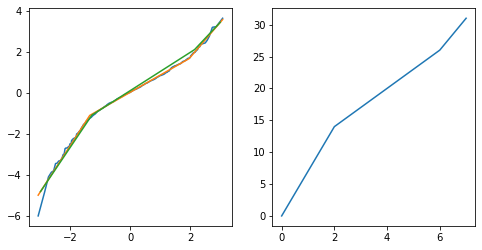

In [35]:
i = np.arange(0, 2**3)
#pl = lambda z : ft.piecewise_linear(z, *coeff_set[0])
#plt.plot(xs[0], np.vectorize(pl)(xs[0]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(xs[0], ys[0])
ax1.plot(xs[0], np.vectorize(pl_set[0])(xs[0]))
ax1.plot(i_to_xs[0](i), j_to_ys[0](i_to_js[0](i)))
ax2.plot(i, i_to_js[0](i))

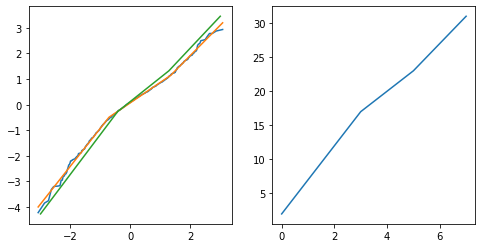

In [3]:
i = np.arange(0, 2**3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(xs[1], ys[1])
ax1.plot(xs[1], np.vectorize(pl_set[1])(xs[1]))
ax1.plot(i_to_xs[1](i), j_to_ys[1](i_to_js[1](i)))
ax2.plot(i, i_to_js[1](i))

In [4]:
num_ancillas = transforms[0].num_ancilla_qubits

qr_input = QuantumRegister(6, 'input') # 2 times 3 registers
qr_objective = QuantumRegister(1, 'objective')
qr_result = QuantumRegister(6, 'result')
qr_ancilla = QuantumRegister(num_ancillas, 'ancilla')
output = ClassicalRegister(6, 'output')

state_preparation = QuantumCircuit(qr_input, qr_objective, qr_result, qr_ancilla, output) 
state_preparation.append(normal, qr_input)

for i in range(2):
    offset = i * 3
    state_preparation.append(transforms[i], qr_input[offset:offset + 3] + qr_result[:] + qr_ancilla[:])

# to calculate the cdf, we use an additional comparator
x_eval = 14
comparator = IntegerComparator(len(qr_result), x_eval + 1, geq=False)
state_preparation.append(comparator, qr_result[:] + qr_objective[:] + qr_ancilla[0:comparator.num_ancillas])

state_preparation.measure(qr_result, output)

# now check
check = False
if check:
    job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))
    var_prob = 0
    for i, a in enumerate(job.result().get_statevector()):
        b = ('{0:0%sb}' % (len(qr_input) + 1)).format(i)[-(len(qr_input) + 1):]
        prob = np.abs(a)**2
        if prob > 1e-6 and b[0] == '1':
            var_prob += prob
    print('Operator CDF(%s)' % x_eval + ' = %.4f' % var_prob)



In [11]:
state_preparation.draw()

┌───────┐┌───────────────────┐                                    »
    input_0: ┤0      ├┤0                  ├────────────────────────────────────»
             │       ││                   │                                    »
    input_1: ┤1      ├┤1                  ├────────────────────────────────────»
             │       ││                   │                                    »
    input_2: ┤2      ├┤2                  ├────────────────────────────────────»
             │  P(X) ││                   │┌───────────────────┐               »
    input_3: ┤3      ├┤                   ├┤0                  ├───────────────»
             │       ││                   ││                   │               »
    input_4: ┤4      ├┤                   ├┤1                  ├───────────────»
             │       ││                   ││                   │               »
    input_5: ┤5      ├┤                   ├┤2                  ├───────────────»
             └───────┘│                   ││                   │┌───────┐      »
objective_0: ─────────┤                   ├┤                   ├┤6      ├──────»
                      │                   ││                   ││       │┌─┐   »
   result_0: ─────────┤3                  ├┤3                  ├┤0      ├┤M├───»
                      │                   ││                   ││       │└╥┘┌─┐»
   result_1: ─────────┤4                  ├┤4                  ├┤1      ├─╫─┤M├»
                      │                   ││                   ││       │ ║ └╥┘»
   result_2: ─────────┤5                  ├┤5                  ├┤2      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
   result_3: ─────────┤6                  ├┤6                  ├┤3      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
   result_4: ─────────┤7                  ├┤7                  ├┤4      ├─╫──╫─»
                      │   pwise_lin_trans ││                   ││   cmp │ ║  ║ »
   result_5: ─────────┤8                  ├┤8                  ├┤5      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
  ancilla_0: ─────────┤9                  ├┤9  pwise_lin_trans ├┤7      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
  ancilla_1: ─────────┤10                 ├┤10                 ├┤8      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
  ancilla_2: ─────────┤11                 ├┤11                 ├┤9      ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
  ancilla_3: ─────────┤12                 ├┤12                 ├┤10     ├─╫──╫─»
                      │                   ││                   ││       │ ║  ║ »
  ancilla_4: ─────────┤13                 ├┤13                 ├┤11     ├─╫──╫─»
                      │                   ││                   │└───────┘ ║  ║ »
  ancilla_5: ─────────┤14                 ├┤14                 ├──────────╫──╫─»
                      │                   ││                   │          ║  ║ »
  ancilla_6: ─────────┤15                 ├┤15                 ├──────────╫──╫─»
                      │                   ││                   │          ║  ║ »
  ancilla_7: ─────────┤16                 ├┤16                 ├──────────╫──╫─»
                      │                   ││                   │          ║  ║ »
  ancilla_8: ─────────┤17                 ├┤17                 ├──────────╫──╫─»
                      │                   ││                   │          ║  ║ »
  ancilla_9: ─────────┤18                 ├┤18                 ├──────────╫──╫─»
                      │                   ││                   │          ║  ║ »
 ancilla_10: ─────────┤19                 ├┤19                 ├──────────╫──╫─»
                      └───────────────────┘└───────────────────┘          ║  ║ »
   output: 6/═══════════════════════════════

In [7]:
#state_preparation.draw()
fig = state_preparation.draw(output='mpl')
fig.savefig('../../../outputs/trans_circuit_detail.pdf', format='pdf', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

<BarContainer object of 38 artists>

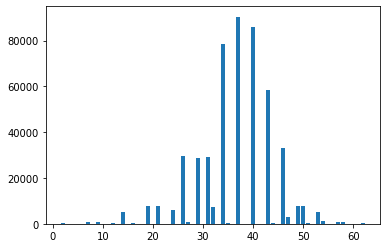

In [23]:
counts = execute(state_preparation, Aer.get_backend('qasm_simulator'), shots = 500000).result().get_counts()
from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)

In [ ]:
IBMQ.save_account("543dce4ab356df3a024dfcf606c9d74a31277e39232f0429dacdb0e00daa3622d02865023f613afd659783251eb5bde6f06e9d0f5f1a95b03fdf8a0d34449bef")
provider = IBMQ.load_account()
provider.backends()
backend = provider.get_backend('ibmq_montreal')

In [31]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeMontreal
device_backend = FakeMontreal() 
sim_be = AerSimulator.from_backend(device_backend)

#sim_ideal = AerSimulator()
#result = sim_ideal.run(transpile(state_preparation, sim_ideal)).result()
#counts = result.get_counts(0)

tcirc = transpile(state_preparation, sim_be)
result_noise = sim_be.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)

In [5]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

# Build noise model from backend properties
#provider = IBMQ.load_account()
from qiskit.test.mock import FakeMontreal
backend = FakeMontreal()
#backend = provider.get_backend('ibmq_montreal')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

counts = execute(state_preparation, Aer.get_backend('qasm_simulator'), 
                #shots = 500000,
                coupling_map=coupling_map,
                basis_gates=basis_gates,
                noise_model=noise_model
                ).result().get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts, title = "transform of normal")
vals = [int(i, 2) for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)


In [13]:
[p_min, p_max]

[array(-4.80060428), array(3.45447725)]

<BarContainer object of 37 artists>

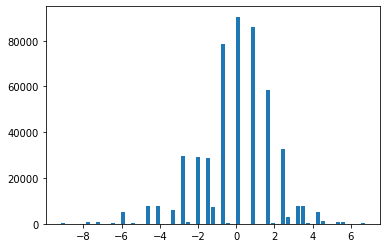

In [18]:
vals2 = p_min * 2 + np.array(vals) * 2 * (p_max - p_min) / 63 
#j_to_ys[0](0)
#j_to_ys[0](31)

plt.bar(vals2, cnts, width = 0.2)

In [22]:
print(time.strftime("%H:%M:%S", time.localtime()))

# now do AE
problem = EstimationProblem(state_preparation=state_preparation,
                    objective_qubits=[len(qr_input)])

# target precision and confidence level
epsilon = 0.01
alpha = 0.05
qi = QuantumInstance(Aer.get_backend('aer_simulator'), shots=100)
ae_cdf = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_cdf = ae_cdf.estimate(problem)


conf_int = np.array(result_cdf.confidence_interval)
print('Estimated value:\t%.4f' % result_cdf.estimation)
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

#state_preparation.draw()

print(time.strftime("%H:%M:%S", time.localtime()))

23:05:23
Estimated value:	0.0161
Confidence interval: 	[0.0143, 0.0180]
23:17:36


In [79]:
def get_sims(normal_distribution):
    import numpy as np
    values = normal_distribution._values
    probs = normal_distribution._probabilities
    # we generate a bunch of realisation of values, based 
    upper_bounds = [0.0]
    stop = 0.0
    for val, prob in zip(values, probs):
        stop += prob
        upper_bounds.append(stop)
    
    np.random.seed = 101
    r = np.random.uniform(low=0.0, high=1.0, size=1000000)
    indices = np.searchsorted(upper_bounds, r, side='left', sorter=None) - 1

    g1, g2 = np.meshgrid(range(2**3), range(2**3), indexing="ij",)
    i1 = g1.flatten()[indices]
    i2 = g2.flatten()[indices]
    #x = list(zip(*(grid.flatten() for grid in meshgrid)))
    return i1, i2

i1, i2 = get_sims(normal)
j1 = i_to_js[0](i1)
j2 = i_to_js[1](i2)
j_tot = j1 + j2

<BarContainer object of 37 artists>

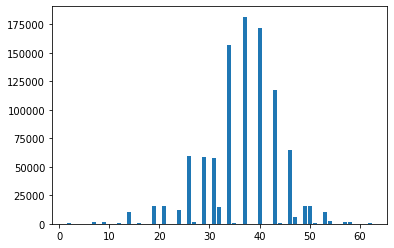

In [83]:
counts = {}
for item in j_tot:
    if item in counts:
        counts[item] += 1
    else:
        counts[item] = 1

vals = [i for i,j in counts.items()]
cnts = [j for i,j in counts.items()]
plt.bar(vals, cnts)

In [20]:
sum = 0
for v,c in zip(vals, cnts):
    if v <= 14:
        sum += c
print(float(sum) / 1000000)

0.015673
